<a href="https://colab.research.google.com/github/maxxx580/twitter-sentiment-analysis/blob/master/twitter_sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentimental Analysis

Zixiang Ma - 
MIE - MENG

## Install and load modules

In [0]:
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install wordcloud
!pip install bs4
!pip install nltk

from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import matplotlib
import warnings

In [0]:
%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data cleaning



### Define helper function used for data cleaning

**clean** function is used for data cleaning. It remove special character, stop word, and url from the tweet message. Both regular expression and BeautifulSoup module are used to clean the text. The nltk.corpus.stopword is used to identify stopword. **Character @ and # are not yet removed at this stage, because they are used to identify the airline refered in a tweet message. **

In [0]:
# Reference to remove url: https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string
def clean(txt):
    # remove html tags
    txt = re.sub(r'/<[^>]+>/', '', txt)
    # remove url
    txt = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','', txt)
    # remove special characters
    txt = re.sub(r'[^A-Za-z0-9 \s \# \@]+', '', txt)
    # to lower case
    txt = txt.strip().lower()
    # remove stop word
    txt = re.sub(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*', '', txt)
    soup = BeautifulSoup(txt, "html.parser")
    return ''.join(soup.findAll(text=True))

**get_sentiment ** converts sentiment from text ''positive" and "negative" into a numerical value. 4 means postive sentiment, 0 means otherwise. 

In [0]:
def get_sentiment(txt):
    return 4 if txt.lower() == 'positive' else 0

### Clean the airline twitter message
Open the file US_airline_tweets.csv and starts processing information with the following steps. 
- Clean each tweet message using the clean helper function defined above.
- Convert sentiment into integer 0 or 1 for analysis purpuses. **0 means negative and 1 means positive**. 
- Clean the negative_reason column using the **get_reason** helper function defined above.
- Concat all tweet message into a single string **airline_twt_combined** in order to find the vocabulary of this us airline tweets. 

In [0]:
airline_twt_combined = ''
df_airline_twt = pd.read_csv('US_airline_tweets.csv')
airline_cleaned_twt = []

for index, row in df_airline_twt.iterrows():
    twt_cleaned = clean(row['text'])
    airline_twt_combined += ' ' + twt_cleaned
    
    airline_cleaned_twt.append(twt_cleaned)
    df_airline_twt.loc[index, 'sentiment'] = get_sentiment(row['sentiment'])

In [0]:
df_airline_twt.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,4,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,0,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,0,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,0,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,4,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


### Clean the generic twitter message
Open file generic_tweets.txt and parse this file line by line with the following steps. 

- The sentimental value is parsed as int and the text is parsed as string. 
- Determine the length of the cleaned tweets. 
- The text string is cleaned by calling the clean function defined above (url, special character, stop word, and emoji are removed). 
- Concats all tweet message for document vocabulary into a single string **generic_twt_combined**. 

In [0]:
file_generic_twitter = open('generic_tweets.txt', "r", encoding = 'utf-8')
file_generic_twitter_byline = file_generic_twitter.readlines()

generic_twt_combined = ''
cleaned_generic_messages = []
message_length = []
sentimental_scores = []

if len(file_generic_twitter_byline) > 1:
    file_generic_twitter_byline = file_generic_twitter_byline[1:]

for line in file_generic_twitter_byline:
    line_sparated = line.split(',')
    sentimental_scores.append(int(line_sparated[0].strip('\"')))
    raw_twt = re.sub('\"[0,4]\",\"[0-9]*\",\".*\",\".*\",\".*\",', '', line)
    
    twt_cleaned = clean(raw_twt).replace('#', '').replace('@', '')
    cleaned_generic_messages.append(twt_cleaned)
    message_length.append(len(raw_twt.split(' ')))
    generic_twt_combined += ' ' + twt_cleaned

df_generic_twt = pd.DataFrame ({
        'sentiment':sentimental_scores,
        'text': cleaned_generic_messages,
        'length':message_length
})

In [0]:
df_generic_twt.head()

,length,sentiment,text
0,20,0,switchfoot awww thats bummer shoulda got da...
1,22,0,upset cant update facebook texting might cry ...
2,19,0,kenichan dived many times ball managed save 50...
3,11,0,whole body feels itchy like fire
4,22,0,nationwideclass behaving im mad cant see


## Exploratory analysis


### Determine what airlines associated with tweet

#### Helper functions
- **get_hash_tags**: helper function to retrieve all hash tags from a tweet. 
- **get_airline_from_twt**: helper function to determine what airlines are mentioned in one tweet. The search is done by checking if name of airlines are mention with character '@' or '#'. If multiple airlines are mentioned in one tweet, all of them will be returned in a list. 
- **get_airline_from_user**: helper function to determine if the user/author is related to a airline. 

In [0]:
def get_hash_tags(tw):
    p = re.compile('\#([a-zA-Z]*)')
    return p.findall(tw)

# A list contains all the airline name in the most basic fashion
airline_names = ['united', 'delta', 'southwest', 'jetblue', 'american',\
                 'spirit', 'suncountry', 'virginamerica', 'usairway', 'us airway',\
                'hawaiian airlines', 'alaska airlines']

def get_airline_from_twt(tw):
    p = re.compile('\@[a-zA-Z]*')
    matches = p.findall(tw)
    airlines = []
    for match in matches:
        for name in airline_names:
            if name in match and name not in airlines:
                airlines.append(name)
    matches = get_hash_tags(tw)
    for match in matches:
        for name in airline_names:
            if name in match and name not in airlines:
                airlines.append(name)
    return airlines

def get_airline_from_user(username):
    for name in airline_names:
        if name in username.lower():
            return [name]
    return []

#### Determine what airlines are associated with the tweet message
- Determine what airlines are associated with the tweet message by checking @, # and tweet author. 
- Count the occurrence of airline names in the message and record if the sentiment is positive or not. If multiple airlines are mentioned in one tweet, all of them are recorded. 

In [0]:
airline_count = {}
airlines_ = []
cnt_no_airline_found = 0
for index, row in df_airline_twt.iterrows():
    airlines = get_airline_from_twt(airline_cleaned_twt[index])
    if not airlines: 
      airlines = get_airline_from_user(row['user'])
    if not airlines:
      cnt_no_airline_found += 1
    airlines_.append(airlines)
    for airline in airlines:
        sentiment = row['sentiment']
        if airline not in airline_count:
            airline_count[airline] = {4:0, 0:0}
        airline_count[airline][sentiment] += 1
print('Fails to extract airline from %d tweets'% cnt_no_airline_found)
print(airline_count)

Fails to extract airline from 0 tweets
{'virginamerica': {4: 152, 0: 190}, 'southwest': {4: 574, 0: 1219}, 'jetblue': {4: 546, 0: 969}, 'united': {4: 497, 0: 2672}, 'american': {4: 354, 0: 2106}, 'delta': {4: 4, 0: 71}, 'usairway': {4: 275, 0: 2319}, 'spirit': {4: 2, 0: 8}}


{'american': {0: 2087, 4: 353},
 'delta': {0: 71, 4: 4},
 'jetblue': {0: 960, 4: 539},
 'southwest': {0: 1212, 4: 572},
 'spirit': {0: 8, 4: 2},
 'united': {0: 2646, 4: 495},
 'usairway': {0: 2307, 4: 274},
 'virginamerica': {0: 187, 4: 150}}

#### What can you say about the distribution of the US airlines of the tweets


There are eight different airlines found from the the US airline tweet dataset. The United airline is mentioned in 3142 tweet, which is more than any other airlines. The Spirit airline is only mentioned in 10 tweet, and it is the least mentioned airline in this data set. Generally speaking, there are more negative sentiment tweet than positive one. 

### Plot word cloud for 100 most frequently used words

#### Tokenize the tweet message in both data set. 

In [0]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('\w+')
airline_tokenized = tokenizer.tokenize(airline_twt_combined)
generic_tokenized = tokenizer.tokenize(generic_twt_combined)

#### Find top 100 the most frequently used words from airline tweet. 

In [0]:
airline_freq_dist = nltk.FreqDist(airline_tokenized)
airline_common_word = airline_freq_dist.most_common(100)

####Find top 100 the most frequently used words from gerneric tweet. 

In [0]:
generic_freq_dist = nltk.FreqDist(generic_tokenized)
generic_common_word = generic_freq_dist.most_common(100)

#### Build word cloud for US airline tweet common words

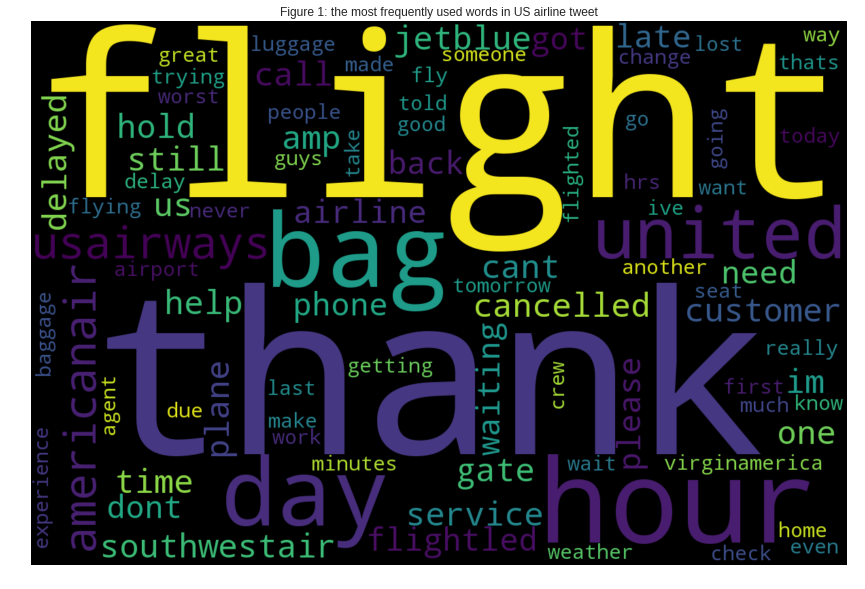

In [0]:
from wordcloud import WordCloud

airline_space_separated = ' '.join(w[0] for w in airline_common_word)
airline_wordcloud = WordCloud(width = 1200, height = 800).generate(airline_space_separated)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('Figure 1: the most frequently used words in US airline tweet')
plt.axis("off")
plt.show()

#### Build word cloud for generic tweet

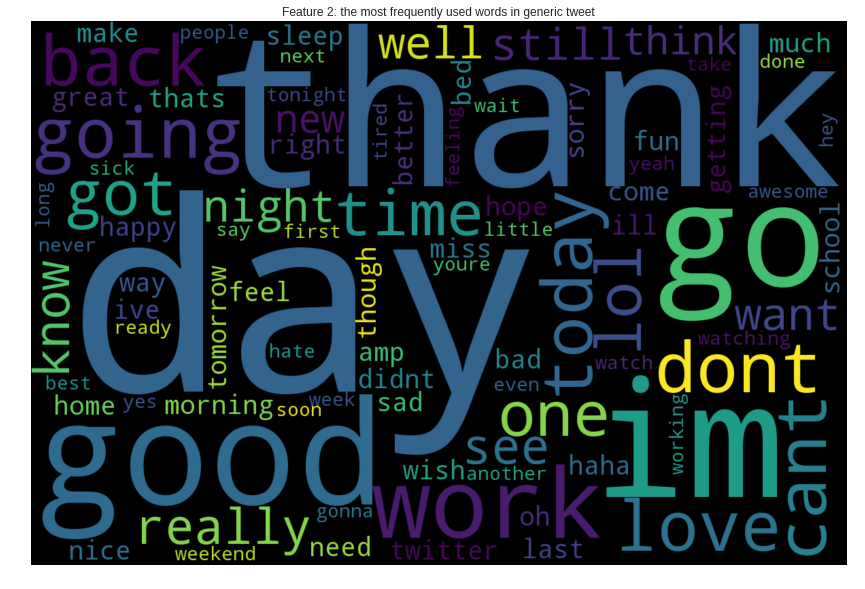

In [0]:
generic_space_separated = ' '.join(w[0] for w in generic_common_word)
generic_wordcloud = WordCloud(width = 1200, height = 800).generate(generic_space_separated)

plt.figure(figsize=(20,10))
plt.title('Feature 2: the most frequently used words in generic tweet')
plt.imshow(generic_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bonus: further explore the data

#### Positive and negative sentiment distribution by airlines
Plot a grouped bar chart to descripe the number of positive and negative tweet message associated with each airline. 

In [0]:
name = []
positive_cnt = []
negatiev_cnt = []

for key in airline_count.keys():
    name.append(key)
    positive_cnt.append(airline_count[key][4])
    negatiev_cnt.append(airline_count[key][0])

In [0]:
# Reference: https://web.archive.org/web/20170228011551/http://matplotlib.org/examples/api/barchart_demo.html
# This function is modified based on the one privided in matplotlib documentation shown above.
def autolabel(rects, isfloat=False):
    """
    Attach a text label above each bar displaying its height
    """
    if isfloat:
      for rect in rects:
          height = rect.get_height()
          ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                  '%.2f' % float(height),
                  ha='center', va='bottom')
    else:
      for rect in rects:
          height = rect.get_height()
          ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                  '%d' % int(height),
                  ha='center', va='bottom')

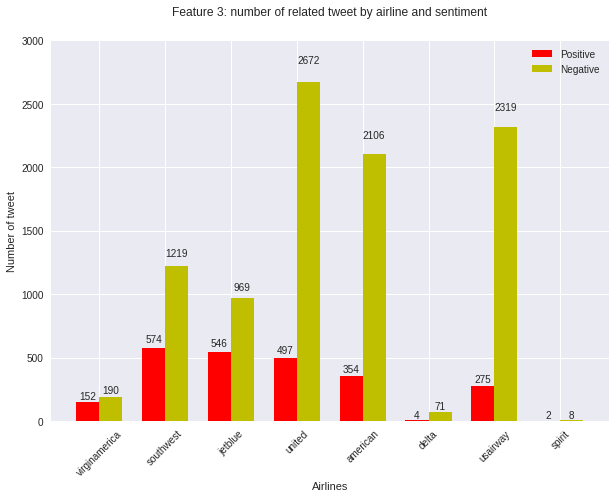

In [0]:
fig, ax = plt.subplots(figsize=(10,7))

ind = np.arange(len(name))
width = 0.35

p1 = ax.bar(ind,positive_cnt,width,color='r')
p2 = ax.bar(ind+width,negatiev_cnt,width,color='y')

autolabel(p1)
autolabel(p2)

ax.set_title('Feature 3: number of related tweet by airline and sentiment',y=1.05)
ax.set_ylabel('Number of tweet')
ax.set_xlabel('Airlines')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(name)
ax.set_ylim(0,3000)

ax.legend((p1[0], p2[0]), ('Positive', 'Negative'))

plt.xticks(rotation=45)
plt.show()

#### US airline negative reason distribution
Figure 4 below presents the how the negative reason is made of. The reason can't tell is accounted for the lartest portion, which is 33.7%, followed by the customer services issue at 31.7%. Longline is the least seen reason, which only occupies 0.8% of the total reasons. 

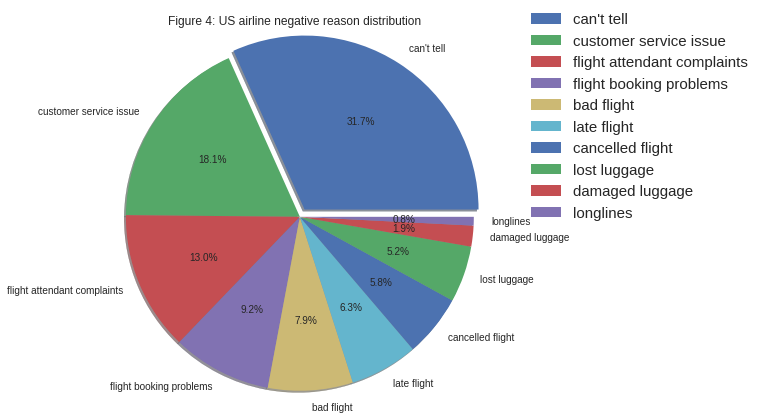

In [0]:
reasons = ["can't tell", 'customer service issue', 'flight attendant complaints',\
           'flight booking problems', 'bad flight', 'late flight', 'cancelled flight',\
           'lost luggage', 'damaged luggage', 'longlines']
values=df_airline_twt.query('sentiment==0').negative_reason.value_counts()
plt.suptitle("Figure 4: US airline negative reason distribution",y=1.2)
wedges, plt_labels, junk  = plt.pie(values,autopct='%1.1f%%',radius=2,labels=reasons,\
                                   explode=[0.1,0,0,0,0,0,0,0,0,0],shadow=True)
plt.legend(wedges, reasons, bbox_to_anchor=(1.5,1.5),prop={'size':15})

#### US airlines tweet sentiment distribution
Figure 5 represents the distribution of positive and negative sentiment in the US airline tweet dataset. 79.5% of the tweets in this file shows negative sentiment, while in contrast only 20.5% shows positive sentitment. 

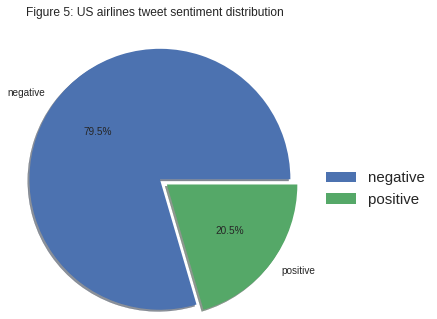

In [0]:
labels = ['negative', 'positive']
values=df_airline_twt.sentiment.value_counts()
plt.suptitle("Figure 5: US airlines tweet sentiment distribution",  y=1.1)
wedges, plt_labels, junk  = plt.pie(values,labels=labels,autopct='%1.1f%%',\
                                    explode=[0,0.1],radius=1.5,shadow=True)
plt.legend(wedges, labels, bbox_to_anchor=(1.2,0.6),prop={'size':15})

#### Generic tweet sentimt distribution
This pie chart represents the distribution of positive and negative sentiment in the generic tweet dataset. The sentiments in this dataset in equally distributed as it is shown in Figure 6 below. 

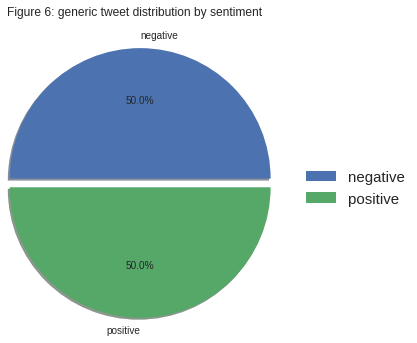

In [0]:
values = df_generic_twt.sentiment.value_counts()
plt.suptitle("Figure 6: generic tweet distribution by sentiment", y=1.1)
wedges, plt_labels, junk  = plt.pie(values,labels=labels,autopct='%1.1f%%',\
                                    radius=1.5,explode=[0,0.1],shadow=True)
plt.legend(wedges, labels, bbox_to_anchor=(1.2,0.6),prop={'size':15})

#### Generic tweet length distribution by sentiments
Figure 7 depicts the tweet length distribution for negative sentiment, while figure 8 illustrates the positive tweet length distribution.  Two histgram shows similar trends where length of the tweets mostly range between 5 and 30 words. 

Text(0.5, 1.0, 'Figure 8: positive tweet length distribution')

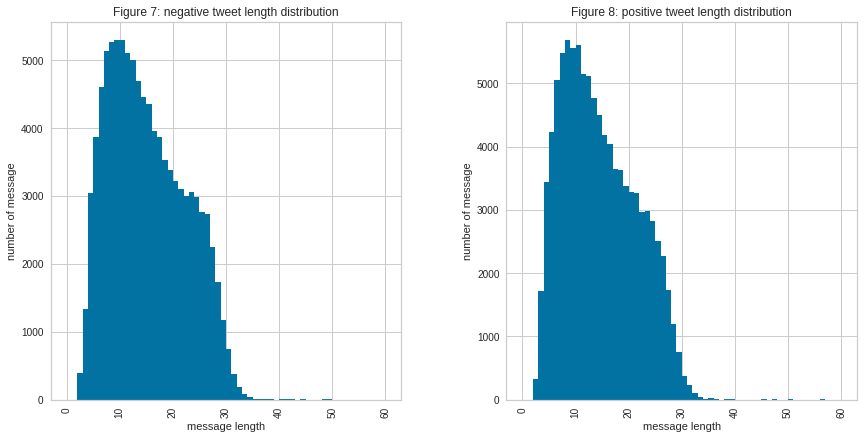

In [0]:
ax_arr = df_generic_twt.hist('length',by='sentiment',figsize=(14,7),\
                             range=[0, 60],bins=60)
for ax in ax_arr.flatten():
    ax.set_xlabel("message length")
    ax.set_ylabel("number of message")
ax_arr.flatten()[0].set_title("Figure 7: negative tweet length distribution")
ax_arr.flatten()[1].set_title("Figure 8: positive tweet length distribution")

## Model Preparation


### Prepare feature and label for generic tweet for sentimental prediction using TfidfVectorizer
Count cectorizer is used over IF-IDF vectorizer when preparing the model because IF-IDF vectorizer reduces the impact of words that are common through the document. However, in our case here some common word such as 'cancel' or 'delay' is crucial to determine the sentiment of text message. The count vectorizer is trained based on the generic tweet vocabulary, and only top 2000 words are selected as feature for sake of efficiency and avoiding model overfitting. 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=2000,ngram_range=[1,2])
X_generic = tfidf_vectorizer.fit_transform(df_generic_twt['text'])
y_generic = df_generic_twt['sentiment']
X_train_generic, X_test_generic, y_train_generic, y_test_generic = train_test_split(X_generic,y_generic,test_size=0.3,\
                                                                                   random_state = 0)

### Prepare feature and label for airline tweet for sentimental prediction using TfidfVectorizer
Use the tfidf vectorizer to transform us airline tweet based on generic tweet's vocabulary. 

In [0]:
X_airline = tfidf_vectorizer.transform(airline_cleaned_twt)
y_airline = df_airline_twt['sentiment']

## Model implementation


### Bonus: hyperparameter tuning
- The value of **parameter C** represents Inverse of regularization strength. By choosing a correct C parameter, it prevents the logistic regression from overfitting the training data. As a large amount of features are used in this model, it is already unlikely to underfit. GridSearchCV is used to test the model with various C parameter ranging from 0.001 to 100. The value gives out the best performance on cross validation will be used later. 




In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(random_state=0, solver='sag', penalty='l2'),param_grid,cv=5)
grid.fit(X_train_generic,y_train_generic)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='sag',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print('The highest score achived on cross validation is %f and the optimized C parameter is %f' % (grid.best_score_,grid.best_params_['C']))

The highest score achived on cross validation is 0.756636 and the optimized C parameter is 1.000000


### Train logistic regression model with generic tweet and evaluate it with test set
A logistic regression is trained with 70% of the generic tweet data and parameters discussed in the previous section. The model shows **75.93% accuracy** when applied on the generic test set. Figure 9 shows the classification report where precision, recall, and f1 score are all in a reasonable range. 

- **random_state** is set to a constatn value zero to ensure the model behave identically. 
- **solver** is set to sag as the training set is sufficiently large. The feature developed by tfidfverctorizer is scaled and this can ensure sag converges during opmization. The sag is used instead of saga because saga takes much more iteration to converge than sag does.  
- **penalty** is set to l2 as it is the only option supported by sag solver. 


The accuracy predicting generic tweet test data: 75.930000 % and the accuracy on test set is 76.577857 %


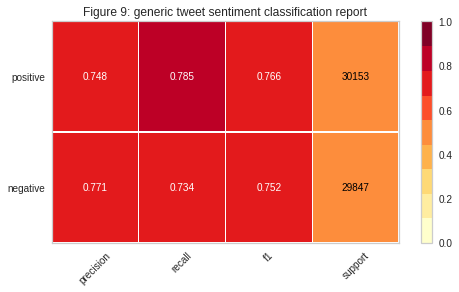

In [0]:
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
import seaborn as sns

model_generic = LogisticRegression(solver='sag',C=grid.best_params_['C'],random_state=0,penalty='l2')
model_generic.fit(X_train_generic,y_train_generic)

predicts_train = model_generic.predict(X_train_generic)
predicts = model_generic.predict(X_test_generic)

accuracy_train = accuracy_score(y_train_generic, predicts_train) * 100
accuracy = accuracy_score(y_test_generic, predicts) * 100

print("The accuracy predicting generic tweet test data: %f %% and the accuracy on test set is %f %%" % (accuracy, accuracy_train))

visualizer = ClassificationReport(model_generic, classes=['negative', 'positive'], support=True,\
                                  title='Figure 9: generic tweet sentiment classification report',size=(500,300))
visualizer.score(X_test_generic, y_test_generic) * 100
visualizer.poof()

### Apply the model to US airline tweet and evaluate the model
The logistic regression model is applied on the complete US airline tweet dataset. The model shows **75.09% accuracy**, which is close to the accuracy when applied on generic test set.  Because negative sentiment tweet makes up 79% of the entire dataset, the precision on negative sentiment slightly increases from 0.771 to 0.957. On the other hand, precision on positive sentiment shows significant decline because of the unbalanced data. 

The accuracy predicting generic tweet test data: 75.097479 %


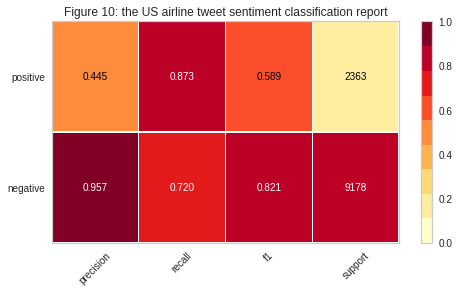

In [0]:
visualizer = ClassificationReport(model_generic, classes=['negative', 'positive'], support=True,\
                                  title='Figure 10: the US airline tweet sentiment classification report',\
                                  size=(500,300))

accuracy = visualizer.score(X_airline, y_airline) * 100
print("The accuracy predicting generic tweet test data: %f %%" % accuracy)
visualizer.poof() 

### Building multi classification logistic regression to predict reasons for negative comment

The multi-class logistic regression is trained with one vs the rest method and the accuracy is **59.11%**. Acoording to figure 11, this model can only predict outcome reasonably well on lost luggage, damaged luggage, flight booking problems, and customer service issue. All data related with longlines and bad flight are misclassified. 

In [0]:
df_airline_twt_negative = df_airline_twt.query('sentiment==0')
y_reason = df_airline_twt_negative['negative_reason']
X_reason_raw = df_airline_twt_negative['text']

tfidf_vectorizer2 = TfidfVectorizer(max_features=2000,ngram_range=[1,2])
X_reason = tfidf_vectorizer2.fit_transform(X_reason_raw)

X_train_reason, X_test_reason, y_train_reason, y_test_reason = train_test_split(X_reason, y_reason, test_size=0.3,\
                                                                               random_state = 0)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The accuracy predicting generic tweet test data: 59.114016 %


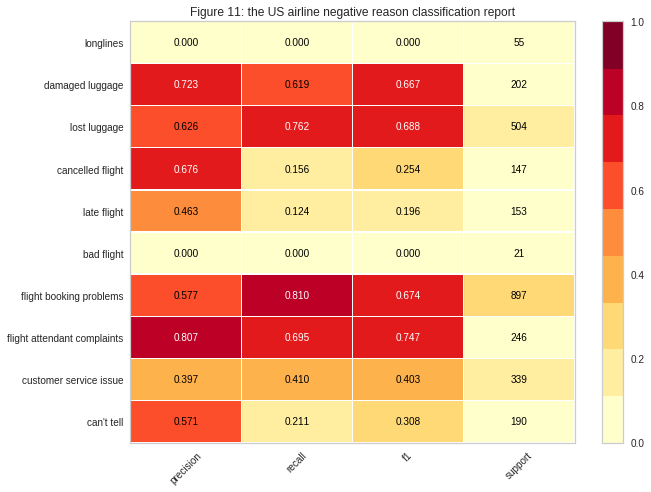

In [0]:
model_reason = LogisticRegression(multi_class='ovr',random_state=0,solver='sag')
model_reason.fit(X_train_reason,y_train_reason)

visualizer = ClassificationReport(model_reason, classes=reasons, support=True,\
                                  title='Figure 11: the US airline negative reason classification report',\
                                  size=(700, 500))
accuracy = visualizer.score(X_test_reason, y_test_reason) * 100
print("The accuracy predicting generic tweet test data: %f %%" % accuracy)
visualizer.poof()

## Result

 - To understand how does public opinion view US airlines, we need to find how the generic tweet classifier labels the sentiment on US airline tweets. The generic tweet classifier will process all US airline tweets and label them as positive or negative sentiments. Occurrence of airline names in the tweet will be recorded along with the sentiment of the message. Figure 12 shows the how many time each airline's name shows up in a message with positive and negative sentiment. United airline is the most mentioned airline with 1923 occurrence in negative sentiment and 1213 with positive one. USairway is in the second place by totol occurrence, and it is closely followed by the American airline. Spirit airline on the other hand is the least-mentioned airline with only 10 occurrence. Public option on each airline can be evaluated by the ratio of number of occurrence with positive sentiment to negative. By this stanadard, only two airline are viewed positively by the public, and they are VirginAmerican and Jetblue. VirginAmerican has the best public option with the ratio of 1.29, and Jetblue is in second place with ratio 1.13 (see figure 13). Airlines that are viewed negatively by the public in descending order: usairway, american, united, delta, spirit, and southwest (figure 13).  

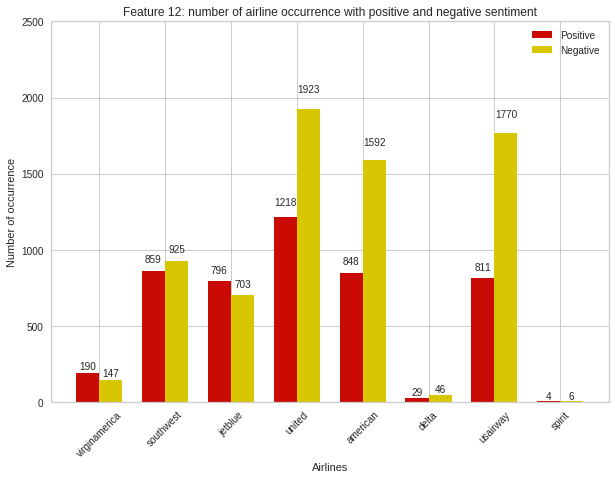

In [0]:
airline_count_predicted = {}
predict_airline_all = model_generic.predict(X_airline)
for index, sentiment in enumerate(predict_airline_all):
  for airline in airlines_[index]:
    if airline not in airline_count_predicted:
      airline_count_predicted[airline] = {4:0, 0:0}
    airline_count_predicted[airline][sentiment] += 1

name = []
positive_cnt = []
negatiev_cnt = []

for key in airline_count_predicted.keys():
    name.append(key)
    positive_cnt.append(airline_count_predicted[key][4])
    negatiev_cnt.append(airline_count_predicted[key][0])

fig, ax = plt.subplots(figsize=(10,7))

ind = np.arange(len(name))
width = 0.35

p1 = ax.bar(ind,positive_cnt,width,color='r')
p2 = ax.bar(ind+width,negatiev_cnt,width,color='y')

autolabel(p1)
autolabel(p2)

ax.set_title('Feature 12: number of airline occurrence with positive and negative sentiment')
ax.set_ylabel('Number of occurrence')
ax.set_xlabel('Airlines')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(name)
ax.set_ylim(0,2500)

ax.legend((p1[0], p2[0]), ('Positive', 'Negative'))

plt.xticks(rotation=45)
plt.show()

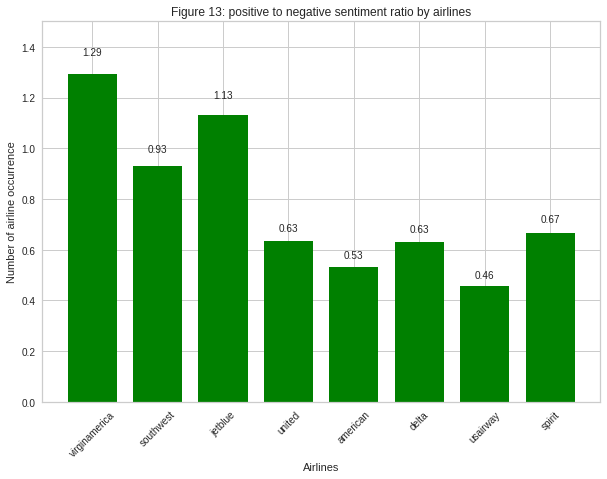

In [0]:
ratio = [p/n for p,n in zip(positive_cnt,negatiev_cnt)]

fig, ax = plt.subplots(figsize=(10,7))

ind = np.arange(len(name))
width = 0.75

p1 = ax.bar(ind,ratio,width,color='green')

autolabel(p1,isfloat=True)

ax.set_title('Figure 13: positive to negative sentiment ratio by airlines')
ax.set_ylabel('Number of airline occurrence')
ax.set_xlabel('Airlines')
ax.set_xticks(ind)
ax.set_xticklabels(name)
ax.set_ylim(0,1.5)

plt.xticks(rotation=45)
plt.show()

- Why second model fails to predict the reasons. 
  - The first reasons why this classifier fails is the criteria to classify each reason is ambiguous even to human and features overlaps each other. The record #298 below has the tweet: ***@VirginAmerica All of group E was told there was no more room in the bins. when I got on the plane, was room for at least 4 bags in my row!***. This was labeled as filight attendent complaints, but it can also be reasonably classified as bad flight, as the classifier dose below. Tweet labelled with reason can't tell usually contains miscellaneous reason such as record #51 below, and this is a noise to mislead the classifier. 
  - Another reason for the low performance is the number of reason is unbalanced. According to figure 4 reason like longlines is only acconted for small portion of the dataset. It is insufficient for the classifier to learn and make predictions given such little information. In figure 11, all data related with longlines are misclassified. 

In [0]:
reasons_predicted = model_reason.predict(X_reason)
df_airline_twt_negative['predicted_reasons'] = reasons_predicted
df_airline_twt_negative[['negative_reason','text','predicted_reasons']].query('negative_reason != predicted_reasons').head(50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,negative_reason,text,predicted_reasons
1,Bad Flight,@VirginAmerica it's really aggressive to blast...,Customer Service Issue
16,Can't Tell,@VirginAmerica why are your first fares in May...,Customer Service Issue
21,Can't Tell,@VirginAmerica What happened 2 ur vegan food o...,Customer Service Issue
22,Bad Flight,@VirginAmerica amazing to me that we can't get...,Customer Service Issue
31,Flight Booking Problems,"@VirginAmerica Hey, first time flyer next week...",Customer Service Issue
35,Flight Booking Problems,@VirginAmerica hi! i'm so excited about your $...,Customer Service Issue
41,Late Flight,"@VirginAmerica Hi, Virgin! I'm on hold for 40-...",Customer Service Issue
44,Flight Attendant Complaints,@VirginAmerica your airline is awesome but you...,Customer Service Issue
51,Can't Tell,@VirginAmerica I have no interesting flying wi...,Cancelled Flight
54,Can't Tell,@VirginAmerica Why is the site down? When wil...,Customer Service Issue


 - For both models, lemmatization can be performed on the text to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. For example, words like cancelled or cancellation will be transformed into its base form cancel. This will help the model to classify sentiments more accurately. 

## Bonus: alternative classification method
Three additional classifier Naive Baise, Support Vector Machine, and Random Forest are trained in comparison to the performance of logistic regression. For efficiency purposes, only 5000 record of data in the training set is used to tain all the models. They will be validated with the generic tweet test set and the complete US airline tweet dataset. Models are judged by accuracy and weighted average of f1 score. A logistic regression is trained with 5000 record of data and without hyperparameter to make this a fair comparison. 

In [0]:
classifiers = ['Naive Baise', 'SVM', 'Random Forest', 'Logistic Regression']
accuracies = {'us airline':[], 'test set':[]}
f1_scores = {'us airline':[], 'test set':[]}

###Naive Baise classifier

#### Train a Naive Baise classifer with generic tweet and evaluate the model

In [0]:
X_generic_arr = X_generic.toarray()
X_airline_arr = X_airline.toarray()
X_train_generic, X_test_generic, y_train_generic, y_test_generic = train_test_split(X_generic_arr,\
                                                                                    y_generic,test_size=0.3,\
                                                                                    random_state=0)

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

gnb = GaussianNB()
gnb.fit(X_train_generic[:5000],y_train_generic[:5000])

predictions = gnb.predict(X_test_generic)
accuracy = accuracy_score(y_test_generic,predictions) * 100
f1 = f1_score(y_test_generic, predictions, average='weighted')

print("The accuracy predicting generic tweet test data: %f %% and weighted f1 score is %f" % (accuracy, f1))

accuracies['test set'].append(accuracy)
f1_scores['test set'].append(f1)

The accuracy predicting generic tweet test data: 64.578333 % and weighted f1 score is 0.641508


#### Apply the model from previous step on US Airline dataset and evaluate it

In [0]:
predictions = gnb.predict(X_airline_arr)
accuracy = accuracy_score(y_airline,predictions)*100
f1 = f1_score(y_airline,predictions,average='weighted')

print("The accuracy predicting generic tweet test data: %f %% and weighted f1 score is %f" % (accuracy, f1))

accuracies['us airline'].append(accuracy)
f1_scores['us airline'].append(f1)

The accuracy predicting generic tweet test data: 52.109869 % and weighted f1 score is 0.561188


###Support Vector Machine Classifier

#### Train a SVM with generic tweet and evaluate model using test set

In [0]:
from sklearn.svm import SVC

X_train_generic, X_test_generic, y_train_generic, y_test_generic = train_test_split(X_generic,y_generic,test_size=0.3,\
                                                                                    random_state=0)
svc = SVC()
svc.fit(X_train_generic[:5000], y_train_generic[:5000])

predictions = svc.predict(X_test_generic)
accuracy = accuracy_score(y_test_generic,predictions)*100
f1 = f1_score(y_test_generic, predictions, average='weighted')

print("The accuracy predicting generic tweet test data: %f %% and weighted f1 score is %f" % (accuracy, f1))

accuracies['test set'].append(accuracy)
f1_scores['test set'].append(f1)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The accuracy predicting generic tweet test data: 50.255000 % and weighted f1 score is 0.336171


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Apply svm model to the US airline data set and evaluate model

In [0]:
predictions = svc.predict(X_airline_arr)
accuracy = accuracy_score(y_airline,predictions)*100
f1 = f1_score(y_airline,predictions,average='weighted')

print("The accuracy predicting generic tweet test data: %f %% and weighted f1 score is %f" % (accuracy, f1))

accuracies['us airline'].append(accuracy)
f1_scores['us airline'].append(f1)

The accuracy predicting generic tweet test data: 20.474829 % and weighted f1 score is 0.069594


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


###Random Forest Classifier

#### Train a random forest with generic tweet and evaluate model using test set

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_generic[:5000],y_train_generic[:5000])
predictions = rfc.predict(X_test_generic)
accuracy = accuracy_score(y_test_generic,predictions)*100
f1 = f1_score(y_test_generic, predictions, average='weighted')

print("The accuracy predicting generic tweet test data: %f %% and weighted f1 score is %f" % (accuracy, f1))

accuracies['test set'].append(accuracy)
f1_scores['test set'].append(f1)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy predicting generic tweet test data: 68.513333 % and weighted f1 score is 0.685093


#### Apply random forest model to the US airline dataset and evaluate model

In [0]:
predictions = rfc.predict(X_airline_arr)
accuracy = accuracy_score(y_airline,predictions)*100
f1 = f1_score(y_airline,predictions,average='weighted')

print("The accuracy predicting generic tweet test data: %f %% and weighted f1 score is %f" % (accuracy, f1))

accuracies['us airline'].append(accuracy)
f1_scores['us airline'].append(f1)

The accuracy predicting generic tweet test data: 65.531583 % and weighted f1 score is 0.688558


### Logistic regression

#### Train a logistic regression model with generic tweet and evaluate model using test set

In [0]:
lgr = LogisticRegression()
lgr.fit(X_train_generic[:5000],y_train_generic[:5000])
predictions = lgr.predict(X_test_generic)
accuracy = accuracy_score(y_test_generic,predictions)*100
f1 = f1_score(y_test_generic, predictions, average='weighted')

print("The accuracy predicting generic tweet test data: %f %% and weighted f1 score is %f" % (accuracy, f1))

accuracies['test set'].append(accuracy)
f1_scores['test set'].append(f1)


The accuracy predicting generic tweet test data: 71.845000 % and weighted f1 score is 0.718159


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


####Apply logistic regression model to the US airline dataset and evaluate model

In [0]:
predictions = lgr.predict(X_airline_arr)
accuracy = accuracy_score(y_airline,predictions)*100
f1 = f1_score(y_airline,predictions,average='weighted')

print("The accuracy predicting generic tweet test data: %f %% and weighted f1 score is %f" % (accuracy, f1))

accuracies['us airline'].append(accuracy)
f1_scores['us airline'].append(f1)

The accuracy predicting generic tweet test data: 64.855732 % and weighted f1 score is 0.682010


### Comparsion

#### Plot a grouped bar chart to compare accuracy
According to figure 12, logistic regression performs the best on generic test set and US airline dataset. The accuracy is 71.84% and 64.86% for test set and US airline dataset respectively. In contrast, SVM performs the worst. The accuracy is 50.26%, while it is only 20.47% on US airline dataset.  

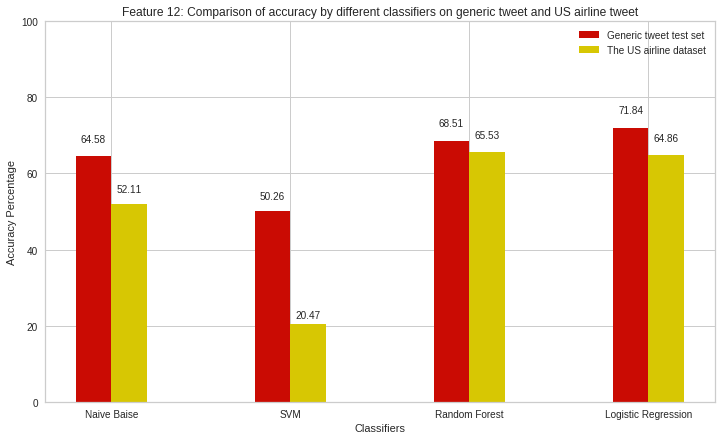

In [0]:
fig, ax = plt.subplots(figsize=(12,7))

ind = np.arange(len(classifiers))
width = 0.2
p1 = ax.bar(ind,accuracies['test set'],width,color='r',bottom=0)
p2 = ax.bar(ind + width, accuracies['us airline'], width,
            color='y', bottom=0)

autolabel(p1,isfloat=True)
autolabel(p2,isfloat=True)

ax.set_title('Feature 12: Comparison of accuracy by different classifiers on generic tweet and US airline tweet')
ax.set_ylabel('Accuracy Percentage')
ax.set_xlabel('Classifiers')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(classifiers)
ax.set_ylim(0,100)

ax.legend((p1[0], p2[0]), ('Generic tweet test set', 'The US airline dataset'))

plt.show()

#### Plot a grouped bar chart to compare weighted average of f1 score
The weighted average of f1 score shows similar pattern with the accuracy. Logistic regression performs the best with 0.72 on generic tweet test set and 0.68 on US airline dataset. It is closely followed by random forest classifer with 0.68 on generic tweet test set and 0.67 on US airline dataset. SVM shows the worst performance with 0.34 on generic tweet test set and 0.07 on US airline dataset. 

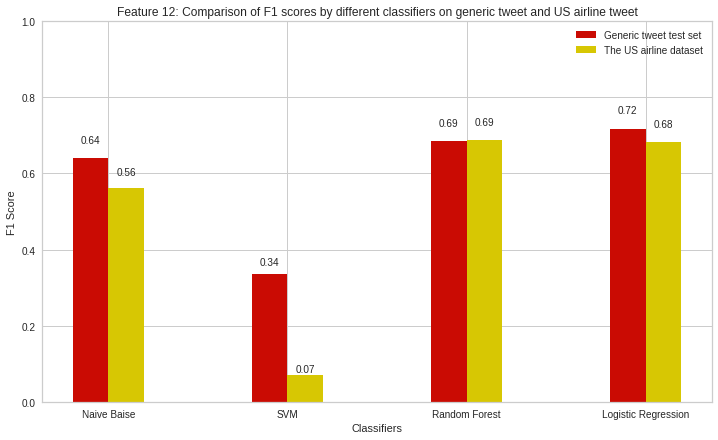

In [0]:
fig, ax = plt.subplots(figsize=(12,7))

ind = np.arange(len(classifiers))
width = 0.2
p1 = ax.bar(ind,f1_scores['test set'],width,color='r',bottom=0)
p2 = ax.bar(ind + width, f1_scores['us airline'], width,
            color='y', bottom=0)

autolabel(p1,isfloat=True)
autolabel(p2,isfloat=True) 

ax.set_title('Feature 12: Comparison of F1 scores by different classifiers on generic tweet and US airline tweet')
ax.set_ylabel('F1 Score')
ax.set_xlabel('Classifiers')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(classifiers)
ax.set_ylim(0, 1)

ax.legend((p1[0], p2[0]), ('Generic tweet test set', 'The US airline dataset'))

plt.show()